In [1]:
import numpy, pandas
import matplotlib.pyplot as plt

# Function Definitions

In [137]:
CHIP = 0 # 2 Bit Chip number

# definitions based on https://gitlab.cern.ch/compass/coral/-/blob/dec427bdfce2089470d7a8e4076f915911431e0b/src/calorim/CsTimingInfo.cc
def read_maps():
    # scrid, port, channel -> x y
    return pandas.read_csv("timing_corrections/ECAL2ms.csv", delimiter=',', usecols=[1,2,3,4,5], verbose=True, skip_blank_lines=True).dropna()

def read_ec02_shift():
    return pandas.read_csv("timing_corrections/corr", delimiter='\t', engine='python', dtype='int', skip_blank_lines=True, usecols=['# Run','Spill','location','-direction'])

def loc_2_coors(location):
    location -= 1
    srcid = location >> 6
    port = (location & 0x3f) >> 3
    channel = location & 7
    return srcid, port, channel

def timing_correction(data, maps, shift):
    global CHIP
    map_dict = maps.query('X == {}'.format(data['X'])).query('Y == {}'.format(data['Y'])).to_dict(orient='list')
    loc = ((map_dict['src_id'][0] - 616) << 6) + (map_dict['port'][0] << 3) + (map_dict['channel'][0] >> 3) + (CHIP << 1) # this last number corresponds to the chip
    t0_corr_dict = shift.query('location == {}'.format(loc)).to_dict(orient='list')
    if data['Spill'] in t0_corr_dict['Spill']:
        data['t0_corr'] = t0_corr_dict['-direction'][t0_corr_dict['Spill'].index(data['Spill'])]
    else:
        data['t0_corr'] = 0
    return data

# Load Data Files

In [3]:
fit_data = pandas.read_csv("timing_corrections/fit_20210616_165753.csv", delimiter=',', usecols=["# Run", "Spill", "X", "Y", "t0", "t0_alt"])
#fit_data = pandas.read_csv('timing_corrections/fit_2009_digits_p*.csv', delimiter=',', usecols=["# Run", "Spill", "X", "Y", "t0", "t0_alt"])
fit_data['# Run'] = fit_data['Y'].astype('int')
fit_data['Spill'] = fit_data['Spill'].astype('int')
fit_data['X'] = fit_data['X'].astype('int')
fit_data['Y'] = fit_data['Y'].astype('int')
fit_data['t0'] = fit_data['t0'].astype('float64')
fit_data['t0_alt'] = fit_data['t0_alt'].astype('float64')
fit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12595 entries, 0 to 12594
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   # Run   12595 non-null  int32  
 1   Spill   12595 non-null  int32  
 2   X       12595 non-null  int32  
 3   Y       12595 non-null  int32  
 4   t0      12595 non-null  float64
 5   t0_alt  12595 non-null  float64
dtypes: float64(2), int32(4)
memory usage: 393.7 KB


# Load Pameters Files

In [4]:
maps = read_maps()
maps['src_id'] = maps['src_id'].astype('int')
maps['channel'] = maps['channel'].astype('int')
maps['port'] = maps['port'].astype('int')
maps['X'] = maps['X'].astype('int')
maps['Y'] = maps['Y'].astype('int')
maps.info()

Tokenization took: 1.00 ms
Type conversion took: 1.00 ms
Parser memory cleanup took: 0.00 ms
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3068 entries, 0 to 3183
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   src_id   3068 non-null   int32
 1   port     3068 non-null   int32
 2   channel  3068 non-null   int32
 3   X        3068 non-null   int32
 4   Y        3068 non-null   int32
dtypes: int32(5)
memory usage: 83.9 KB


In [5]:
shift = read_ec02_shift()
shift.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4611 entries, 0 to 4610
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   # Run       4611 non-null   int32
 1   Spill       4611 non-null   int32
 2   location    4611 non-null   int32
 3   -direction  4611 non-null   int32
dtypes: int32(4)
memory usage: 72.2 KB


# Execute Corrections

In [138]:
fit_data = fit_data.apply(timing_correction, maps=maps, shift=shift, axis=1)
fit_data["t0_corrected"] = fit_data["t0"] - fit_data["t0_corr"]
fit_data["t0_alt_corrected"] = fit_data["t0_alt"] - fit_data["t0_corr"]

# Alternative T0 Histograms

## Not corrected

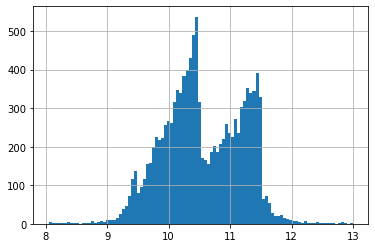

In [139]:
fit_data.loc[(fit_data["t0_alt"] > 8) & (fit_data["t0_alt"] <13), "t0_alt"].hist(bins=100)

## Corrected

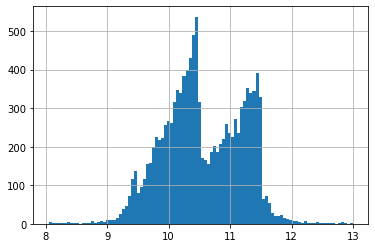

In [140]:
fit_data.loc[(fit_data["t0_alt_corrected"] > 8) & (fit_data["t0_alt_corrected"] <13), "t0_alt_corrected"].hist(bins=100)

## Per-Spill Histogram Corrected T0 alternate

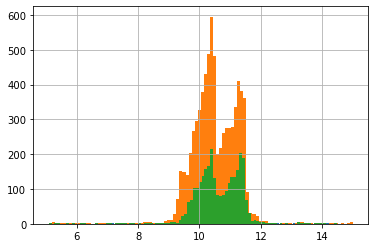

In [141]:
fit_data.loc[(fit_data["t0_alt_corrected"] > 5) & (fit_data["t0_alt_corrected"] <15) & (fit_data["Spill"] == 82.0), "t0_alt_corrected"].hist(bins=100)
fit_data.loc[(fit_data["t0_alt_corrected"] > 5) & (fit_data["t0_alt_corrected"] <15) & (fit_data["Spill"] == 83.0), "t0_alt_corrected"].hist(bins=100)
fit_data.loc[(fit_data["t0_alt_corrected"] > 5) & (fit_data["t0_alt_corrected"] <15) & (fit_data["Spill"] == 84.0), "t0_alt_corrected"].hist(bins=100)

# T0 Fitted

## Not Corrected

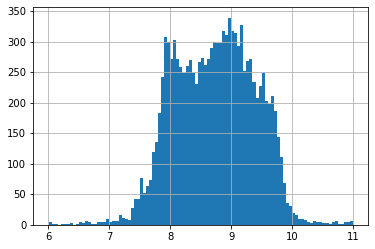

In [142]:
fit_data.loc[(fit_data["t0"] > 6) & (fit_data["t0"] <11), "t0"].hist(bins=100)

## Corrected

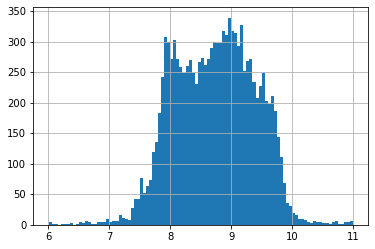

In [143]:
fit_data.loc[(fit_data["t0_corrected"] > 6) & (fit_data["t0_corrected"] <11), "t0_corrected"].hist(bins=100)

## Per-Spill Histogram Corrected Times

8.845041826641676 1.0928694094166085


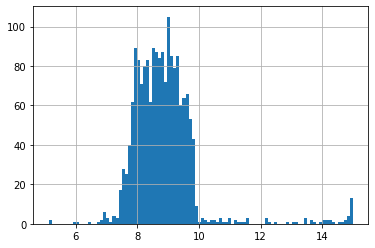

In [144]:
fit_data.loc[(fit_data["t0_corrected"] > 5) & (fit_data["t0_corrected"] <15) & (fit_data["Spill"] == 82.0), "t0_corrected"].hist(bins=100)
print(fit_data.loc[(fit_data["t0_corrected"] > 5) & (fit_data["t0_corrected"] <15) & (fit_data["Spill"] == 82.0), "t0_corrected"].mean(), fit_data.loc[(fit_data["t0_corrected"] > 5) & (fit_data["t0_corrected"] <15) & (fit_data["Spill"] == 82.0), "t0_corrected"].std())

8.84594837614084 1.1033279424647726


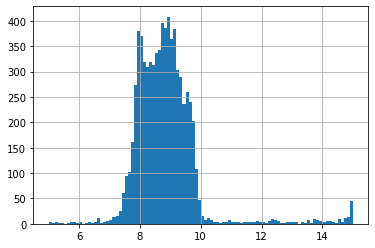

In [145]:
fit_data.loc[(fit_data["t0_corrected"] > 5) & (fit_data["t0_corrected"] <15) & (fit_data["Spill"] == 83.0), "t0_corrected"].hist(bins=100)
print(fit_data.loc[(fit_data["t0_corrected"] > 5) & (fit_data["t0_corrected"] <15) & (fit_data["Spill"] == 83.0), "t0_corrected"].mean(), fit_data.loc[(fit_data["t0_corrected"] > 5) & (fit_data["t0_corrected"] <15) & (fit_data["Spill"] == 83.0), "t0_corrected"].std())

8.958495044924803 1.1263811695284778


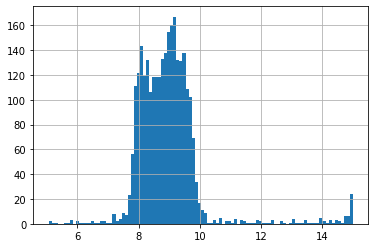

In [146]:
fit_data.loc[(fit_data["t0_corrected"] > 5) & (fit_data["t0_corrected"] <15) & (fit_data["Spill"] == 84.0), "t0_corrected"].hist(bins=100)
print(fit_data.loc[(fit_data["t0_corrected"] > 5) & (fit_data["t0_corrected"] <15) & (fit_data["Spill"] == 84.0), "t0_corrected"].mean(), fit_data.loc[(fit_data["t0_corrected"] > 5) & (fit_data["t0_corrected"] <15) & (fit_data["Spill"] == 84.0), "t0_corrected"].std())